# Collaborative filtering recommender system

In [134]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, rank
from pyspark.sql.window import Window
from matplotlib import pyplot as plt
spark = (
    SparkSession
    .Builder()
    .appName('cf-project')
    .getOrCreate()
)

## dataset import

In [135]:
#importing datasets:

ratings = spark.read.csv(path='./dataset/Ratings.csv', header=True, inferSchema=True)
users = spark.read.csv(path='./dataset/Users.csv', header=True, inferSchema=True)
books =  spark.read.csv(path='./dataset/Books.csv', header=True, inferSchema=True)


## Data visualisation

In [136]:
ratings.show(n = 7)

+------+----------+------+
|UserID|      ISBN|Rating|
+------+----------+------+
|276725|034545104X|     0|
|276726|0155061224|     5|
|276727|0446520802|     0|
|276729|052165615X|     3|
|276729|0521795028|     6|
|276733|2080674722|     0|
|276736|3257224281|     8|
+------+----------+------+
only showing top 7 rows



In [137]:
users.show(n = 10)

+------+--------------------+----+
|UserID|            Location| Age|
+------+--------------------+----+
|     1|  nyc, new york, usa|NULL|
|     2|stockton, califor...|18.0|
|     3|moscow, yukon ter...|NULL|
|     4|porto, v.n.gaia, ...|17.0|
|     5|farnborough, hant...|NULL|
|     6|santa monica, cal...|61.0|
|     7| washington, dc, usa|NULL|
|     8|timmins, ontario,...|NULL|
|     9|germantown, tenne...|NULL|
|    10|albacete, wiscons...|26.0|
+------+--------------------+----+
only showing top 10 rows



In [138]:
books.show(n = 10)

+----------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|               Title|              Author|YearOfPublication|           Publisher|           ImageURLS|           ImageURLM|           ImageURLL|
+----------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|             2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|             2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|             1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari Kolata|    

In [139]:
ratings.printSchema()

root
 |-- UserID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Rating: integer (nullable = true)



In [140]:
users.printSchema()

root
 |-- UserID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [141]:
books.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- YearOfPublication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- ImageURLS: string (nullable = true)
 |-- ImageURLM: string (nullable = true)
 |-- ImageURLL: string (nullable = true)



In [142]:
{
    'rating': ratings.count(),
    'users': users.count(),
    'books': books.count()
}

{'rating': 1149780, 'users': 278859, 'books': 271360}

In [143]:
#count null values:
ratings.toPandas().isnull().sum()

UserID    0
ISBN      0
Rating    0
dtype: int64

In [144]:
#null values in users dataset:
users.toPandas().isnull().sum()

UserID           1
Location         0
Age         110518
dtype: int64

In [145]:
#null values in books dataset:
books.toPandas().isnull().sum()

ISBN                 0
Title                0
Author               1
YearOfPublication    0
Publisher            2
ImageURLS            0
ImageURLM            0
ImageURLL            3
dtype: int64

In [146]:
ratings.describe().show()

+-------+------------------+-----------+------------------+
|summary|            UserID|       ISBN|            Rating|
+-------+------------------+-----------+------------------+
|  count|           1149780|    1149780|           1149780|
|   mean|140386.39512602412|   Infinity|2.8669501991685364|
| stddev| 80562.27771851176|        NaN|3.8541838592016657|
|    min|                 2| 0330299891|                 0|
|    max|            278854|  Ô½crosoft|                10|
+-------+------------------+-----------+------------------+



In [147]:
#getting total ratings
total_rating = ratings.count()

#counting occurence of rating values and their frequencies:
rating_values = (
    ratings.groupBy('Rating')
    .agg(count('*').alias('occure'))
    .orderBy(col('occure').desc())
    .withColumn('frequency', col('occure') / total_rating)

)

rating_values.show()

+------+------+--------------------+
|Rating|occure|           frequency|
+------+------+--------------------+
|     0|716109|  0.6228226269373272|
|     8|103736|  0.0902224773434918|
|    10| 78610| 0.06836960114108787|
|     7| 76457| 0.06649706900450521|
|     9| 67541|  0.0587425420515229|
|     5| 50974| 0.04433369862060568|
|     6| 36924|  0.0321139696289725|
|     4|  8904|0.007744090173772374|
|     3|  5996|0.005214910678564595|
|     2|  2759|0.002399589486684409|
|     1|  1770|0.001539424933465...|
+------+------+--------------------+



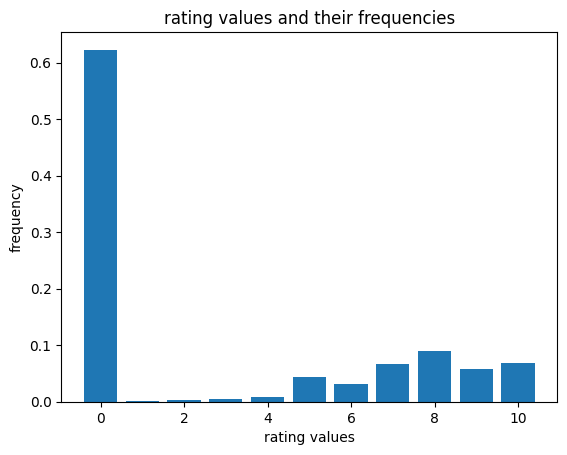

In [148]:
pandas_rating_values = rating_values.toPandas()

plt.bar(pandas_rating_values['Rating'], pandas_rating_values['frequency'])
plt.xlabel('rating values')
plt.ylabel('frequency')
plt.title('rating values and their frequencies')
plt.show()

the rating value '0' mean that user doesn't provide an explicit feedback so we can remove it from our rating dataset

#### search for duplicates

In [149]:
#ensure each user rate a book one time:
(
    ratings.groupBy('UserID', 'ISBN')
    .agg(count('*').alias('rating-times'))
    .orderBy(col('rating-times').desc())
).show(n = 5)

+------+----------+------------+
|UserID|      ISBN|rating-times|
+------+----------+------------+
|276925|8434830809|           1|
|276745| 342310538|           1|
|276798|3442437407|           1|
|276847|347354034X|           1|
|276856|221096900X|           1|
+------+----------+------------+
only showing top 5 rows



#### utility matrix


In [150]:
most_rated_books = (
    ratings.groupBy('ISBN')
    .agg(count('*').alias('rating_times'))
    .orderBy(col('rating_times').desc())
    .limit(500)
    .select('ISBN')
)

most_rated_books.show(n = 10)

+----------+
|      ISBN|
+----------+
|0971880107|
|0316666343|
|0385504209|
|0060928336|
|0312195516|
|044023722X|
|0679781587|
|0142001740|
|067976402X|
|0671027360|
+----------+
only showing top 10 rows



In [151]:
pd_df = (
    most_rated_books
    .join(ratings, on='ISBN', how='left')
    .toPandas()
)

pd_df.head(10)

,ISBN,UserID,Rating
0,0060392452,507,0
1,0060392452,1903,0
2,0060392452,2179,9
3,0060392452,2766,0
4,0060392452,2891,0
5,0060392452,2977,0
6,0060392452,4157,8
7,0060392452,4334,6
8,0060392452,4795,8
9,0060392452,5048,10


In [152]:
pd_df.shape

(112755, 3)

In [153]:
(
    pd_df
    .pivot_table(columns='ISBN', index='UserID', values='Rating', fill_value='*')
)

ISBN,002542730X,006016848X,0060173289,0060175400,0060199652,0060391626,0060392452,0060502258,0060915544,0060921145,...,1400031362,1400034779,155874262X,1558743669,1558744150,1558745157,1559029838,1573225789,1573229326,1878424319
UserID,,,,,,,,,,,,,,,,,,,,,
9,*,*,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
14,*,*,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
16,*,*,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
26,*,*,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
39,*,*,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278832,*,*,*,*,*,*,*,*,*,*,...,*,*,10.0,*,*,*,*,*,*,*
278836,*,*,*,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
278843,*,*,9.0,*,*,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*


In [154]:
#calculate sparsity: 
from pyspark.sql.dataframe import DataFrame

def sparsity(ratings: DataFrame) -> float:
    total_u = ratings.select('UserID').distinct().count()
    total_b = ratings.select('ISBN').distinct().count()
    missing_r = (total_u * total_b) - ratings.count()

    return missing_r * (100 / (total_b * total_u))



print('sparsity of rating matrix: ', sparsity(ratings))

sparsity of rating matrix:  99.99679322889055


the given utility matrix is too sparse

In [155]:
total_users = ratings.select('UserID').distinct().count()
total_books =  ratings.select('ISBN').distinct().count()

print('total users those express there preferences: ', total_users)
print('total books: ', total_books)

total users those express there preferences:  105283
total books:  340556


In [156]:
#calculate total rating for each user:

total_rated_by_user = (
    ratings.groupBy('UserID')
    .agg(count('*').alias('total_rated'))
    .orderBy(col('total_rated').desc())
)

total_rated_by_user.show( n = 10)

+------+-----------+
|UserID|total_rated|
+------+-----------+
| 11676|      13602|
|198711|       7550|
|153662|       6109|
| 98391|       5891|
| 35859|       5850|
|212898|       4785|
|278418|       4533|
| 76352|       3367|
|110973|       3100|
|235105|       3067|
+------+-----------+
only showing top 10 rows



In [157]:
(
    total_rated_by_user
    .select('total_rated')
    .describe()
    .where(col('summary').isin(['min', 'max']))
).show()

+-------+-----------+
|summary|total_rated|
+-------+-----------+
|    min|          1|
|    max|      13602|
+-------+-----------+



In [158]:
total_rated_under_10 = (
    total_rated_by_user
    .where(col('total_rated') <= 10)
    .count() 
)

total_rated_above_10 = (
    total_rated_by_user
    .where(col('total_rated') > 10)
    .count() 
)

print('number of users those rate more than 10 books: ', total_rated_above_10)
print('number of users those rate less than 10 books: ', total_rated_under_10)

number of users those rate more than 10 books:  12053
number of users those rate less than 10 books:  93230


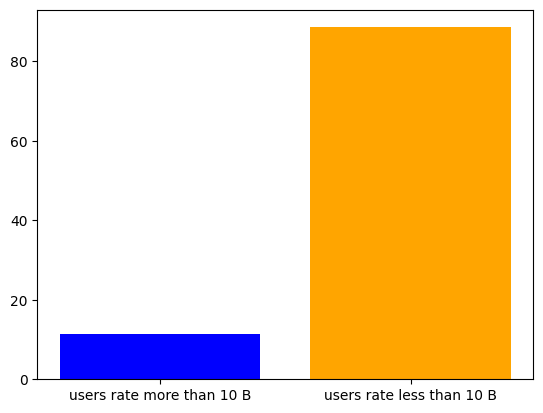

In [159]:
plt.bar(
    ['users rate more than 10 B', 'users rate less than 10 B'],
    [total_rated_above_10 * (100 / total_users), total_rated_under_10 * (100 / total_users)],
    color=['blue', 'orange']
)

plt.show()

## Data cleaning

In [160]:
#removing null values:
users =(
    users
    .select('UserID', 'Location')
    .na
    .drop()
)

print('users lenght: ', users.count())

users lenght:  278858


In [161]:
#removing null values:
books =(
    books
    .na
    .drop()
)

print('books lenght: ', books.count())

books lenght:  271354


In [162]:
#remove zero's :

ratings = ratings.filter(col('Rating') > 0)

new_total_users = ratings.select('UserID').distinct().count()
new_total_books =  ratings.select('ISBN').distinct().count()

print('the new shape of rating dataframe: ', ratings.toPandas().shape)
print('with total users: ', new_total_users)
print('with total books: ', new_total_books)

the new shape of rating dataframe:  (433671, 3)
with total users:  77805
with total books:  185973


In [163]:
#most rated books:
most_rated_books = (
    ratings.groupBy('ISBN')
    .agg(count('*').alias('rating_times'))
    .orderBy(col('rating_times').desc())
    .limit(450)
)

most_rated_books.toPandas().tail(n = 10)


,ISBN,rating_times
440,0375506039,54
441,0440223202,54
442,0553280368,54
443,0671758896,54
444,0385493800,54
445,0553280414,54
446,006099486X,54
447,0385512104,54
448,1559029838,54
449,0553279556,54


In [164]:
ratings_filtered = (
    most_rated_books
    .join(ratings, on='ISBN', how='left')
    .select('UserID', 'ISBN', 'Rating')
)
ratings_filtered.show()

+------+----------+------+
|UserID|      ISBN|Rating|
+------+----------+------+
|  2033|0099428385|     8|
| 60427|0099428385|     7|
| 88352|0099428385|     6|
|163727|0099428385|     8|
|174092|0099428385|     9|
|175759|0099428385|    10|
|194646|0099428385|     8|
|206979|0099428385|     7|
|256247|0099428385|     8|
|  1131|0174434642|     8|
| 76626|0174434642|    10|
|  2439|0345367421|     7|
| 39396|0345367421|     7|
| 46398|0345367421|     7|
|105517|0345367421|     8|
|130705|0345367421|     7|
|193458|0345367421|     7|
|243236|0345367421|     7|
|277873|0395977894|    10|
| 43404|0395977894|     5|
+------+----------+------+
only showing top 20 rows



In [165]:
ratings_filtered.count()

45712

In [166]:
ratings_filtered = (
    ratings_filtered
    .join(users, on='UserID', how='inner')
    .select('UserID', 'ISBN', 'Rating')
)

print('rating length: ', ratings_filtered.count())

rating length:  45712


In [167]:
ratings_filtered = (
    ratings_filtered
    .join(books, on='ISBN', how='inner')
    .select('UserID', 'ISBN', 'Rating')
)

print('rating length: ', ratings_filtered.count())

rating length:  45238


In [168]:
#create a views partitioned by userID:
user_window = Window.partitionBy('UserID')

ratings_filtered = ratings_filtered.withColumn('numBooks', count('*').over(user_window))
ratings_filtered = ratings_filtered.filter(col('numBooks') >= 10)

ratings_filtered.show()

+------+----------+------+--------+
|UserID|      ISBN|Rating|numBooks|
+------+----------+------+--------+
|   254|0451167317|     8|      12|
|   254|0380789035|    10|      12|
|   254|0439136350|     9|      12|
|   254|0439139597|     9|      12|
|   254|0142001740|     9|      12|
|   254|0439136369|     9|      12|
|   254|0451524934|     9|      12|
|   254|0439064864|     9|      12|
|   254|0451526341|     8|      12|
|   254|0671021001|     7|      12|
|   254|0590353403|     9|      12|
|   254|0439064872|     9|      12|
|   638|0670892963|     7|      14|
|   638|0679746048|     7|      14|
|   638|0385504209|    10|      14|
|   638|0316969443|    10|      14|
|   638|0316789089|    10|      14|
|   638|0446531332|    10|      14|
|   638|0385505833|    10|      14|
|   638|0316693200|     9|      14|
+------+----------+------+--------+
only showing top 20 rows



In [169]:
num_books = ratings_filtered.select('ISBN').distinct().count()
num_users = ratings_filtered.select('UserID').distinct().count()

print('number of books: ', num_books)
print('number of users: ', num_users)


number of books:  447
number of users:  670


In [170]:
(
    ratings_filtered
    .toPandas()
    .pivot_table(columns='ISBN', index='UserID', values='Rating', fill_value='0')
)

ISBN,002542730X,006016848X,0060173289,0060175400,0060199652,0060391626,0060392452,0060502258,0060915544,0060921145,...,1400034779,155874262X,1558743669,1558744150,1558745157,1573225789,1573229326,1573229571,1592400876,1878424319
UserID,,,,,,,,,,,,,,,,,,,,,
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1435,0,0,0,0,0,0,0,0,10.0,0,...,0,10.0,0,0,0,0,0,0,0,0
2766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,8.0,0,...,0,0,0,0,0,9.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
print('sparsity of rating matrix: ', sparsity(ratings_filtered))

sparsity of rating matrix:  96.09903502621123


In [172]:
#train and test dataset:

ratings_filtered.show(n = 5)

+------+----------+------+--------+
|UserID|      ISBN|Rating|numBooks|
+------+----------+------+--------+
|   254|0451167317|     8|      12|
|   254|0380789035|    10|      12|
|   254|0439136350|     9|      12|
|   254|0439139597|     9|      12|
|   254|0142001740|     9|      12|
+------+----------+------+--------+
only showing top 5 rows



In [173]:
percent_books_to_mask = 0.3

ratings_filtered = (
    ratings_filtered
    .withColumn('num_books_to_mask', (col('numBooks') * percent_books_to_mask).cast('int'))
    .withColumn('book_rank', rank().over(user_window.orderBy(col('ISBN').desc())))
)

ratings_filtered.show()

+------+----------+------+--------+-----------------+---------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|
+------+----------+------+--------+-----------------+---------+
|   254|0671021001|     7|      12|                3|        1|
|   254|0590353403|     9|      12|                3|        2|
|   254|0451526341|     8|      12|                3|        3|
|   254|0451524934|     9|      12|                3|        4|
|   254|0451167317|     8|      12|                3|        5|
|   254|0439139597|     9|      12|                3|        6|
|   254|0439136369|     9|      12|                3|        7|
|   254|0439136350|     9|      12|                3|        8|
|   254|0439064872|     9|      12|                3|        9|
|   254|0439064864|     9|      12|                3|       10|
|   254|0380789035|    10|      12|                3|       11|
|   254|0142001740|     9|      12|                3|       12|
|   638|0679746048|     7|      14|     

In [174]:
from pyspark.ml.feature import StringIndexer

isbn_indexer = StringIndexer(
    inputCol='ISBN', 
    outputCol='integer_isbn'
).setHandleInvalid('keep')


ratings_filtered = isbn_indexer.fit(ratings_filtered).transform(ratings_filtered)

ratings_filtered.show(n = 7)


+------+----------+------+--------+-----------------+---------+------------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|integer_isbn|
+------+----------+------+--------+-----------------+---------+------------+
|   254|0671021001|     7|      12|                3|        1|        30.0|
|   254|0590353403|     9|      12|                3|        2|        56.0|
|   254|0451526341|     8|      12|                3|        3|       142.0|
|   254|0451524934|     9|      12|                3|        4|       192.0|
|   254|0451167317|     8|      12|                3|        5|       107.0|
|   254|0439139597|     9|      12|                3|        6|        40.0|
|   254|0439136369|     9|      12|                3|        7|       138.0|
+------+----------+------+--------+-----------------+---------+------------+
only showing top 7 rows



In [175]:
#cast integer_isbn to int:
ratings_filtered = (
    ratings_filtered
    .withColumn('integer_isbn', col('integer_isbn').cast('int'))
)

ratings_filtered.show(n = 7)

+------+----------+------+--------+-----------------+---------+------------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|integer_isbn|
+------+----------+------+--------+-----------------+---------+------------+
|   254|0671021001|     7|      12|                3|        1|          30|
|   254|0590353403|     9|      12|                3|        2|          56|
|   254|0451526341|     8|      12|                3|        3|         142|
|   254|0451524934|     9|      12|                3|        4|         192|
|   254|0451167317|     8|      12|                3|        5|         107|
|   254|0439139597|     9|      12|                3|        6|          40|
|   254|0439136369|     9|      12|                3|        7|         138|
+------+----------+------+--------+-----------------+---------+------------+
only showing top 7 rows



In [176]:
train_df = ratings_filtered.filter(col('book_rank') > col('num_books_to_mask'))

test_df = ratings_filtered.filter(col('book_rank') <= col('num_books_to_mask'))

In [177]:
train_df.show(5)

+------+----------+------+--------+-----------------+---------+------------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|integer_isbn|
+------+----------+------+--------+-----------------+---------+------------+
|   254|0451524934|     9|      12|                3|        4|         192|
|   254|0451167317|     8|      12|                3|        5|         107|
|   254|0439139597|     9|      12|                3|        6|          40|
|   254|0439136369|     9|      12|                3|        7|         138|
|   254|0439136350|     9|      12|                3|        8|          31|
+------+----------+------+--------+-----------------+---------+------------+
only showing top 5 rows



In [178]:
test_df.show(5)

+------+----------+------+--------+-----------------+---------+------------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|integer_isbn|
+------+----------+------+--------+-----------------+---------+------------+
|   254|0671021001|     7|      12|                3|        1|          30|
|   254|0590353403|     9|      12|                3|        2|          56|
|   254|0451526341|     8|      12|                3|        3|         142|
|   638|0679746048|     7|      14|                4|        1|         122|
|   638|0670892963|     7|      14|                4|        2|         193|
+------+----------+------+--------+-----------------+---------+------------+
only showing top 5 rows



### Model building

In [179]:
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit


als = ALS(
    userCol='UserID', 
    itemCol='integer_isbn', 
    ratingCol='Rating', 
    coldStartStrategy='drop', 
    nonnegative=True
)


In [180]:
param_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, [1,])
    .addGrid(als.maxIter, [20,])
    .addGrid(als.regParam, [0.05,])
).build()

In [181]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Rating')

In [182]:
cv = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

In [183]:
model = cv.fit(train_df)

In [184]:
best = model.bestModel

print('rank: ', best.rank)
print('MaxIter: ', best._java_obj.parent().getMaxIter())
print('RegParam: ', best._java_obj.parent().getRegParam())

rank:  1
MaxIter:  20
RegParam:  0.05


#### Re-training

In [185]:
mdl = als.fit(train_df)

### Evaluation

In [186]:
results_train = mdl.transform(train_df)

train_rmse = evaluator.evaluate(results_train)


results_train.show()
print('train rmse: ', train_rmse)

+------+----------+------+--------+-----------------+---------+------------+----------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|integer_isbn|prediction|
+------+----------+------+--------+-----------------+---------+------------+----------+
|   254|0451524934|     9|      12|                3|        4|         192|   8.89079|
|   254|0451167317|     8|      12|                3|        5|         107|  8.111741|
|   254|0439139597|     9|      12|                3|        6|          40|  9.246851|
|   254|0439136369|     9|      12|                3|        7|         138|  8.842188|
|   254|0439136350|     9|      12|                3|        8|          31|  8.914899|
|   254|0439064872|     9|      12|                3|        9|          41|  8.774649|
|   254|0439064864|     9|      12|                3|       10|          39|  8.776701|
|   254|0380789035|    10|      12|                3|       11|         149|  9.353507|
|   254|0142001740|     9|      

In [187]:
test_results = mdl.transform(test_df)
test_results.show()

+------+----------+------+--------+-----------------+---------+------------+----------+
|UserID|      ISBN|Rating|numBooks|num_books_to_mask|book_rank|integer_isbn|prediction|
+------+----------+------+--------+-----------------+---------+------------+----------+
|   254|0671021001|     7|      12|                3|        1|          30|  8.238991|
|   254|0590353403|     9|      12|                3|        2|          56|  8.498013|
|   254|0451526341|     8|      12|                3|        3|         142| 7.9538608|
|   638|0679746048|     7|      14|                4|        1|         122|  8.740083|
|   638|0670892963|     7|      14|                4|        2|         193| 6.6132474|
|   638|0446531332|    10|      14|                4|        3|         262|   9.51638|
|   638|0385505833|    10|      14|                4|        4|          62|  9.289095|
|  2766|0553279912|     7|      11|                3|        3|          76|  7.647276|
|  4017|068484477X|     5|      

In [188]:
rmse = evaluator.evaluate(test_results)

print('rmse = ', rmse)

rmse =  2.2909152916066167


In [189]:
mdl.recommendForAllUsers(5).show()

+------+--------------------+
|UserID|     recommendations|
+------+--------------------+
|   254|[{87, 10.024155},...|
|   638|[{386, 11.872586}...|
|  1435|[{165, 10.49667},...|
|  2766|[{10, 9.619271}, ...|
|  4017|[{436, 11.856785}...|
|  6242|[{53, 9.457883}, ...|
|  6251|[{124, 10.511237}...|
|  6543|[{281, 10.037977}...|
|  6563|[{153, 10.731018}...|
|  6575|[{138, 9.772576},...|
|  7158|[{4, 10.441949}, ...|
|  7283|[{386, 11.53569},...|
|  7346|[{436, 9.722032},...|
|  7915|[{153, 10.800841}...|
|  8066|[{386, 10.025443}...|
|  8067|[{27, 10.921689},...|
|  8245|[{94, 9.815214}, ...|
|  8253|[{10, 11.436174},...|
|  8454|[{138, 10.216397}...|
| 10314|[{153, 9.882768},...|
+------+--------------------+
only showing top 20 rows



## Model saving

In [191]:
mdl.save("./collaborative-filteing/init_model")

In [192]:
ratings_filtered.toPandas().to_csv('./final_ratings_x2.csv', index=False)

#### do some recommendations

In [ ]:
spark.stop()